In [1]:
from matplotlib.pyplot import figure
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import Policy, ema_logging, ScalarOutcome

import pickle
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Define the desired problem formulation here
pf = 3
model, _ = get_model_for_problem_formulation(pf)

In [3]:
#We do not understand yet why we need a reference_value, these values are from the std document of dike_model_simulation.py

reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate 0': 3.5, 'discount rate 1': 3.5,
                    'discount rate 2': 3.5,
                    'ID flood wave shape': 4}
scen1 = {}
#comparing scenario's with the reference to select scenario's fitted for the problem
for key in model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})
        
from ema_workbench import Scenario

ref_scenario = Scenario('reference', **scen1)

### Step 1: Generate optimal policies

In [4]:
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

from ema_workbench.em_framework.evaluators import BaseEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

#The model is saving the convergence table every 500 nfr, so chose a large number to analyse trends. 

nfe = 100000

#The amount of values for the epsilon list is dependend on the amount of outputs. 
#the larger you choose your epsilon, the more results you will get
#you could chose a lower epsilon in this case. 

len_out = len(model.outcomes.keys()) #This adjusts the size of Epsilon and Hypervolume to the problem formulation
epsilon = [2] * len_out   

#for now there is still a problem with the HyperVolume function. We could decide to not use it because the EpsilonProgress
#is also helpful findig the total amount of policies to establish the convergence of the policie space.

convergence_metrics = [HyperVolume(minimum=[0]*len_out, maximum=[1.01]*len_out),
                       EpsilonProgress()]

#Run ones with Pickle is false to get results, then you could set Pickle on true to avoid unnesecery run time. =) 
use_pickle1 = True
if use_pickle1:
    with open(f"data/MORDM_results1_pf{pf}.pickle","rb") as filehandler:
        results, convergence = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model) as evaluator:
        #save it as a Tuple 
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario,
                                                  n_processes=10)
###!!!!!!
#Change the amount of processes accordingly. 10 processes is recommended for 6core CPU. 14 processes for 8 core CPU        
###!!!!!!
    #Save results in Pickle file
    with open(f"data/MORDM_results1_pf{pf}.pickle","wb") as filehandler:
        pickle.dump((results,convergence),filehandler)

In [5]:
convergence

hypervolume  epsilon_progress    nfe
0           0.0                 0      0
1           0.0                50    100
2           0.0               167   1198
3           0.0               242   2295
4           0.0               292   3392
..          ...               ...    ...
93          0.0               698  95084
94          0.0               698  96130
95          0.0               698  97131
96          0.0               698  98131
97          0.0               699  99177

[98 rows x 3 columns]

In [6]:
outcomes = results[list(model.outcomes.keys())] #This makes sure that the outcomes are split from the levers/uncertainties 
outcomes.head()

A.1 Total Costs  A.1_Expected Number of Deaths  A.2 Total Costs  \
0     1.800160e+08                       0.000000     4.920871e+07   
1     7.339447e+07                       0.002179     2.953156e+07   
2     6.813900e+07                       0.000000     2.937723e+07   
3     1.071087e+08                       0.007669     2.604532e+07   
4     1.440757e+08                       0.000000     5.706465e+07   

   A.2_Expected Number of Deaths  A.3 Total Costs  \
0                       0.001652     7.026696e+07   
1                       0.012300     4.159096e+07   
2                       0.033816     3.196828e+07   
3                       0.003597     5.934443e+07   
4                       0.065775     8.762288e+07   

   A.3_Expected Number of Deaths  A.4 Total Costs  \
0                       0.110209     5.224735e+06   
1                       0.010068     1.259967e+07   
2                       0.025443     3.314984e+06   
3                       0.000000     7.332080e+06   
4                       0.067969     6.320800e+06   

   A.4_Expected Number of Deaths  A.5 Total Costs  \
0                       0.003231     4.725547e+07   
1                       0.000904     3.012418e+07   
2                       0.002037     2.662839e+07   
3                       0.000000     6.704741e+07   
4                       0.000000     4.655822e+07   

   A.5_Expected Number of Deaths  RfR Total Costs  Expected Evacuation Costs  
0                       0.003373      121200000.0                   0.000000  
1                       0.002041       30700000.0                1722.734378  
2                       0.001749      151900000.0                   0.000000  
3                       0.008898       30700000.0                8214.184567  
4                       0.006896              0.0                   0.000000

X:\Xrogram-Files\Anaconda\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


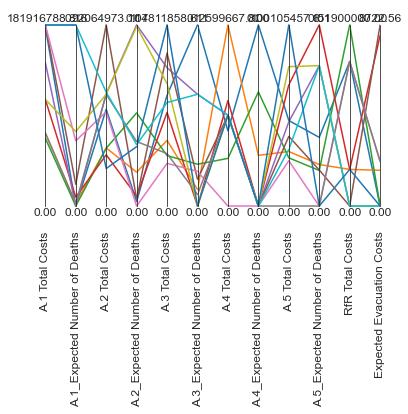

In [7]:
from ema_workbench.analysis import parcoords

#making a pairplot
import matplotlib.pyplot as plt

limits = parcoords.get_limits(outcomes)
limits.loc[0, outcomes.keys()] = 0

axes = parcoords.ParallelAxes(limits, fontsize=12, rot=90)
axes.plot(outcomes)
#plt.savefig(f"images/ParallelAxes_pf{pf}.svg")
plt.show()

In [8]:
convergence
#as seen, the hypervolume stays 0, this indicates an error. 

hypervolume  epsilon_progress    nfe
0           0.0                 0      0
1           0.0                50    100
2           0.0               167   1198
3           0.0               242   2295
4           0.0               292   3392
..          ...               ...    ...
93          0.0               698  95084
94          0.0               698  96130
95          0.0               698  97131
96          0.0               698  98131
97          0.0               699  99177

[98 rows x 3 columns]

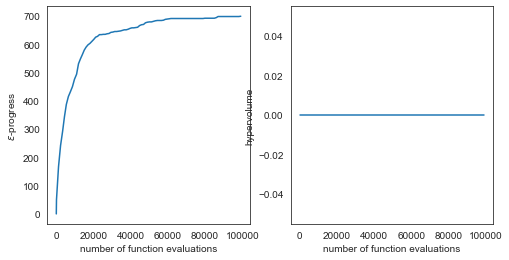

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

### Step 2: Re-evaluate candidate solutions under uncertainty

In [10]:
pf = 3
model, _ = get_model_for_problem_formulation(pf)

In [11]:
ema_logging.log_to_stderr(ema_logging.INFO)

#The model is saving the convergence table every 500 nfr, so chose a large number to analyse trends. 

nfe = 10000

#The amount of values for the epsilon list is dependend on the amount of outputs. 
#the larger you choose your epsilon, the more results you will get
#you could chose a lower epsilon in this case. 

len_out = len(model.outcomes.keys()) #This adjusts the size of Epsilon and Hypervolume to the problem formulation
epsilon = [2] * len_out   

#for now there is still a problem with the HyperVolume function. We could decide to not use it because the EpsilonProgress
#is also helpful findig the total amount of policies to establish the convergence of the policie space.

convergence_metrics = [HyperVolume(minimum=[0]*len_out, maximum=[1.01]*len_out),
                       EpsilonProgress()]

#Run ones with Pickle is false to get results, then you could set Pickle on true to avoid unnesecery run time. =) 
use_pickle1 = True
if use_pickle1:
    with open(f"data/MORDM_results1_pf{pf}.pickle","rb") as filehandler:
        results, convergence = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model) as evaluator:
        #save it as a Tuple 
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  epsilons=epsilon,
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario,
                                                  n_processes=10)
###!!!!!!
#Change the amount of processes accordingly. 10 processes is recommended for 6core CPU. 14 processes for 8 core CPU        
###!!!!!!
    #Save results in Pickle file
    with open(f"data/MORDM_results1_pf{pf}.pickle","wb") as filehandler:
        pickle.dump((results,convergence),filehandler)

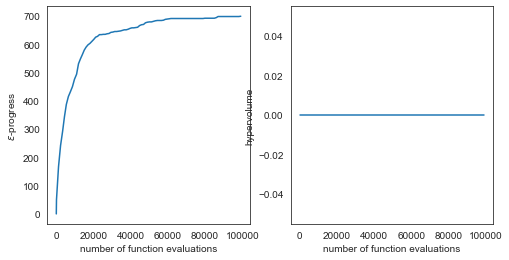

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [13]:
results["A.3_Expected Number of Deaths"] <= 0.01

0     False
1     False
2     False
3      True
4     False
5     False
6     False
7      True
8      True
9     False
10     True
Name: A.3_Expected Number of Deaths, dtype: bool

In [14]:
logical = (results["A.3_Expected Number of Deaths"] <= 0.01)
np.sum(logical)

4

In [15]:
results[logical].head()

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
3         0        0        0        0        0        0        1        0   
7         0        0        0        0        0        0        0        0   
8         0        0        0        0        0        0        0        0   
10        0        0        0        0        0        0        1        0   

    2_RfR 2  3_RfR 0  ...  A.2 Total Costs  A.2_Expected Number of Deaths  \
3         0        0  ...     2.604532e+07                       0.003597   
7         0        0  ...     5.676529e+07                       0.023434   
8         0        0  ...     5.679262e+07                       0.065156   
10        0        0  ...     1.907283e+07                       0.021579   

    A.3 Total Costs  A.3_Expected Number of Deaths  A.4 Total Costs  \
3      5.934443e+07                       0.000000     7.332080e+06   
7      3.321790e+07                       0.007031     6.320800e+06   
8      7.751737e+07                       0.000000     6.320800e+06   
10     1.148119e+08                       0.000000     6.320800e+06   

    A.4_Expected Number of Deaths  A.5 Total Costs  \
3                             0.0     6.704741e+07   
7                             0.0     0.000000e+00   
8                             0.0     7.702540e+07   
10                            0.0     1.001055e+08   

    A.5_Expected Number of Deaths  RfR Total Costs  Expected Evacuation Costs  
3                        0.008898       30700000.0                8214.184567  
7                        0.000000      121200000.0                2141.172625  
8                        0.006896              0.0                   0.000000  
10                       0.000000       30700000.0                   0.000000  

[4 rows x 43 columns]

In [16]:
policies = results[logical]
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies.head()

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
3         0        0        0        0        0        0        1        0   
7         0        0        0        0        0        0        0        0   
8         0        0        0        0        0        0        0        0   
10        0        0        0        0        0        0        1        0   

    2_RfR 2  3_RfR 0  ...  A.2_DikeIncrease 2  A.3_DikeIncrease 0  \
3         0        0  ...                   0                   4   
7         0        0  ...                   0                   0   
8         0        0  ...                   0                   7   
10        0        0  ...                   0                   7   

    A.3_DikeIncrease 1  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
3                    0                   5                   2   
7                    3                   0                   1   
8                    7                   0                   1   
10                   6                   4                   1   

    A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
3                    0                   0                   0   
7                    0                   0                   0   
8                    0                   0                   0   
10                   0                   0                   7   

    A.5_DikeIncrease 1  A.5_DikeIncrease 2  
3                    0                   0  
7                    0                   0  
8                    1                   7  
10                   0                   7  

[4 rows x 31 columns]

In [17]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [18]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle2 = True

if use_pickle2:
    with open(f"data/MORDM_results2_pf{pf}.pickle","rb") as filehandler:
        results2 = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 250
    with MultiprocessingEvaluator(model) as evaluator:
        results2 = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)
    # Save results in Pickle file
    with open(f"data/MORDM_results2_pf{pf}.pickle","wb") as filehandler:
        pickle.dump(results2,filehandler)

In [19]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [20]:
experiments2, outcomes2 = results2

overall_scores = {}
for policy in np.unique(experiments2['policy']):
    scores = {}
    
    logical = experiments2['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes2[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

A.1 Total Costs  A.1_Expected Number of Deaths  A.2 Total Costs  \
10     1.405663e+18                       0.636442     2.925336e+16   
3      9.784336e+17                       0.006253     3.298640e+16   
7      5.832974e+17                       0.030977     4.380459e+16   
8      9.784336e+17                       0.434257     4.609933e+16   

    A.2_Expected Number of Deaths  A.3 Total Costs  \
10                       0.019544     2.856042e+14   
3                        0.000320     6.633576e+15   
7                        0.004006     7.902677e+16   
8                        0.032522     7.427842e+14   

    A.3_Expected Number of Deaths  A.4 Total Costs  \
10                       0.000002     7.989883e+14   
3                        0.000055     5.602144e+14   
7                        0.026735     4.581758e+14   
8                        0.000035     8.536053e+14   

    A.4_Expected Number of Deaths  A.5 Total Costs  \
10                       0.000122     7.617020e+14   
3                        0.000001     2.790839e+16   
7                        0.000007     6.947108e+15   
8                        0.000131     1.649623e+16   

    A.5_Expected Number of Deaths  RfR Total Costs  Expected Evacuation Costs  
10                       0.000005              0.0               0.000000e+00  
3                        0.000333              0.0               5.425205e+08  
7                        0.000728              0.0               1.608698e+08  
8                        0.005782              0.0               0.000000e+00

X:\Xrogram-Files\Anaconda\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


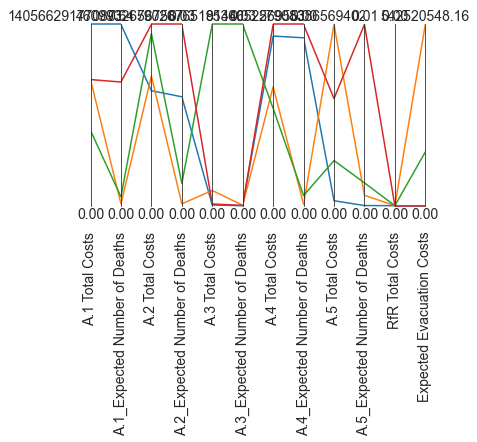

In [21]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, data.keys()] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

### Step 3: Give scores using maximum regret

In [22]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [23]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments2['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes2[outcome.name], 
                         "policy":experiments2['policy'],
                         "scenario":experiments2['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()


C:\Users\Mateo\AppData\Local\Temp\ipykernel_14844\2139178993.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14844\2139178993.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14844\2139178993.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14844\21

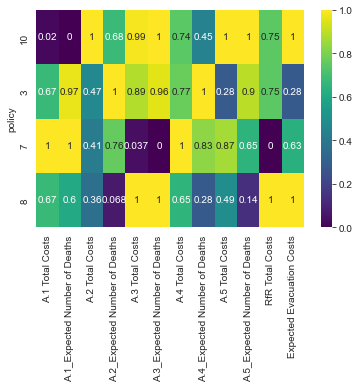

In [24]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

X:\Xrogram-Files\Anaconda\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
X:\Xrogram-Files\Anaconda\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:260: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


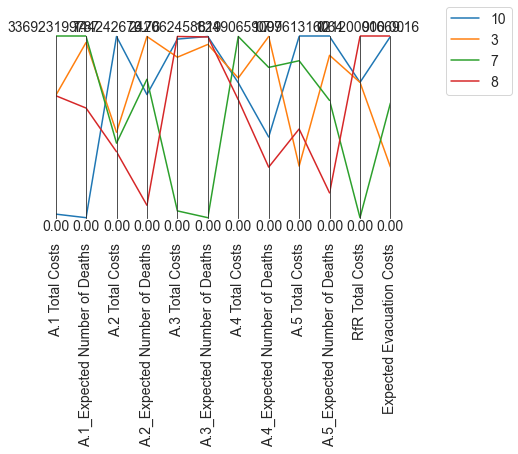

In [25]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, data.keys()] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

In [26]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

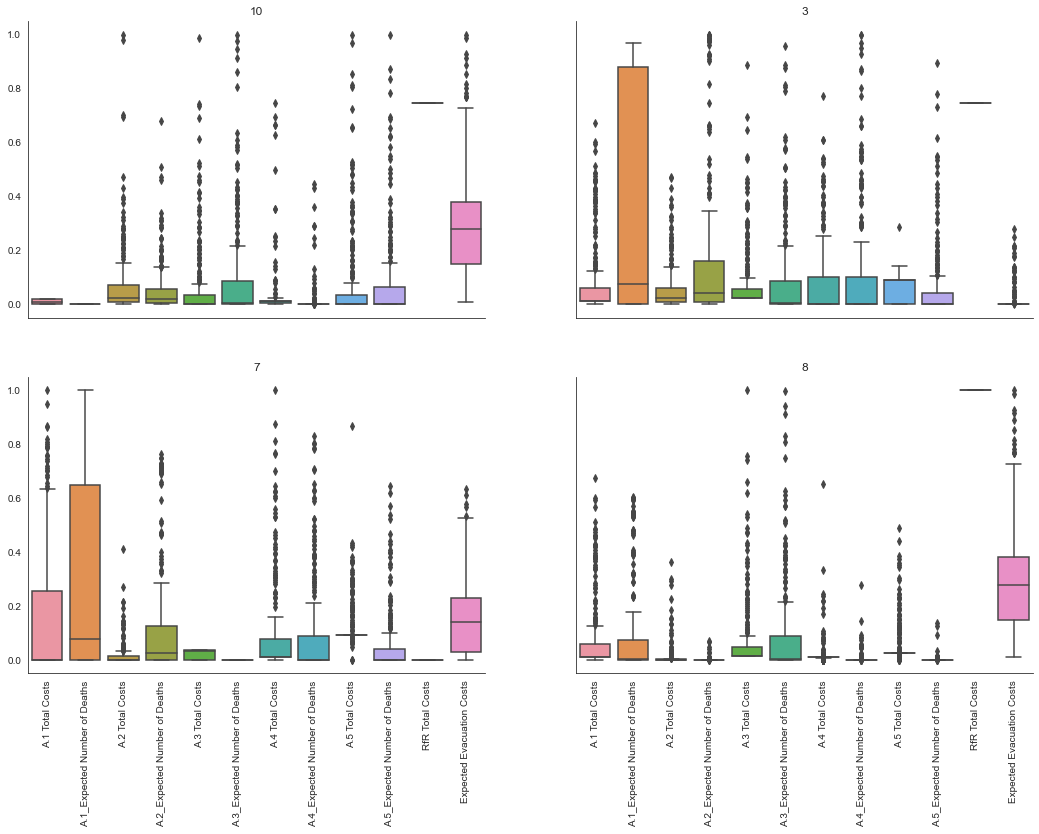

In [27]:
# this generates a 2 by 2 axes grid, with a shared X and Y axis
# accross all plots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18,12), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 
axes = [axes[0,0], axes[0,1],
        axes[1,0], axes[1,1]]

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))

    # Rotate x-axis labels slightly to make them redable
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

X:\Xrogram-Files\Anaconda\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


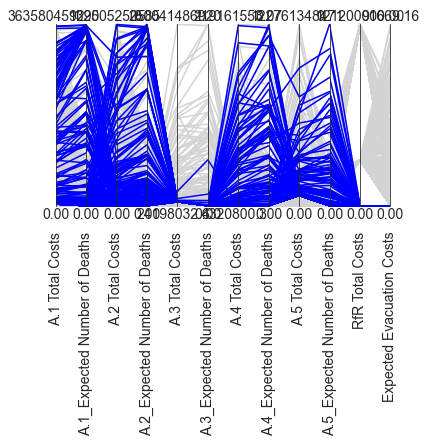

In [28]:
y = logical

data = pd.DataFrame({k:v[y] for k,v in outcomes2.items()})
all_data = pd.DataFrame({k:v for k,v in outcomes2.items()})

limits = parcoords.get_limits(all_data)
axes = parcoords.ParallelAxes(limits)
axes.plot(all_data, color='lightgrey')
axes.plot(data, color='blue')
plt.show()

In [29]:
print(data.idxmax())
print(data.idxmin())

A.1 Total Costs                   81
A.1_Expected Number of Deaths     26
A.2 Total Costs                  129
A.2_Expected Number of Deaths    108
A.3 Total Costs                   87
A.3_Expected Number of Deaths     87
A.4 Total Costs                   12
A.4_Expected Number of Deaths    220
A.5 Total Costs                  106
A.5_Expected Number of Deaths    113
RfR Total Costs                    0
Expected Evacuation Costs          0
dtype: int64
A.1 Total Costs                  2
A.1_Expected Number of Deaths    2
A.2 Total Costs                  1
A.2_Expected Number of Deaths    1
A.3 Total Costs                  0
A.3_Expected Number of Deaths    0
A.4 Total Costs                  0
A.4_Expected Number of Deaths    0
A.5 Total Costs                  0
A.5_Expected Number of Deaths    0
RfR Total Costs                  0
Expected Evacuation Costs        0
dtype: int64


In [30]:
selected = experiments2.loc[[10, 3, 7, 8], ['A.1_DikeIncrease 0', 'A.2_DikeIncrease 0', 'A.3_DikeIncrease 0', 'A.4_DikeIncrease 0', 'A.5_DikeIncrease 0', '0_RfR 0', '1_RfR 0', '2_RfR 0', '3_RfR 0', '4_RfR 0']]
selected

A.1_DikeIncrease 0  A.2_DikeIncrease 0  A.3_DikeIncrease 0  \
10                 0.0                 0.0                 4.0   
3                  0.0                 0.0                 4.0   
7                  0.0                 0.0                 4.0   
8                  0.0                 0.0                 4.0   

    A.4_DikeIncrease 0  A.5_DikeIncrease 0  0_RfR 0  1_RfR 0  2_RfR 0  \
10                 2.0                 0.0      0.0      0.0      1.0   
3                  2.0                 0.0      0.0      0.0      1.0   
7                  2.0                 0.0      0.0      0.0      1.0   
8                  2.0                 0.0      0.0      0.0      1.0   

    3_RfR 0  4_RfR 0  
10      0.0      0.0  
3       0.0      0.0  
7       0.0      0.0  
8       0.0      0.0

In [31]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [32]:
from sklearn import preprocessing

experiments_of_interest = experiments2.loc[y]
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes2.items()})

# normalize outcomes on unit interval to ensure equal weighting of outcomes
x = outcomes_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_outcomes = pd.DataFrame(x_scaled, columns=outcomes_df.columns)

In [33]:
import itertools

n_scen = experiments2.loc[y].shape[0]
indices = range(n_scen)
set_size = 3
n_scen
combinations2 = itertools.combinations(indices, set_size)
combinations = list(combinations2)

In [34]:
from scipy.spatial.distance import pdist, squareform

def evaluate_diversity_single(indices, distances, weight=0.5, distance='euclidean'):
    '''
    takes the outcomes and selected scenario set (decision variables), 
    returns a single 'diversity' value for the scenario set.
    outcomes : outcomes dictionary of the scenario ensemble
    decision vars : indices of the scenario set
    weight : weight given to the mean in the diversity metric. If 0, only minimum; if 1, only mean
    '''
    i, j = [e for e in zip(*itertools.combinations(indices, 2))]
    subset_distances = distances[i, j]
    minimum = np.min(subset_distances)
    mean = np.mean(subset_distances)
    diversity = (1-weight)*minimum + weight*mean
    
    return [diversity]


def find_maxdiverse_scenarios(distances, combinations):
    scores = []
    for indices in combinations:
        diversity = evaluate_diversity_single(indices, distances)
        scores.append((diversity, indices))

    return scores

In [35]:
import random

sampled_combinations = random.sample(combinations, 100000) #was 100000
#sampled_combinations 

In [36]:
from concurrent.futures import ProcessPoolExecutor
import os
import functools

distances = squareform(pdist(normalized_outcomes.values))

results = find_maxdiverse_scenarios(distances, sampled_combinations)

In [37]:
results.sort(key=lambda entry:entry[0], reverse=True)
most_diverse = results[0]
most_diverse

([2.000930104756379], (6, 81, 129))

In [38]:
from ema_workbench import Scenario

selected = experiments2.loc[most_diverse[1], ['A.3_DikeIncrease 0', '0_RfR 0', '1_RfR 0', '2_RfR 0', '3_RfR 0', '4_RfR 0']]
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [39]:
print(len(scenarios))
print(len(model.outcomes))

3
12


In [40]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle3 = True

if use_pickle3:
    with open(f"data/MORDM_results3_pf{pf}.pickle","rb") as filehandler:
        results3 = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    from ema_workbench import MultiprocessingEvaluator, ema_logging
    from ema_workbench.em_framework.evaluators import BaseEvaluator

    from ema_workbench.em_framework.optimization import (HyperVolume,
                                                         EpsilonProgress)

    ema_logging.log_to_stderr(ema_logging.INFO)

    nfe = 10000

    #len_out = len(model.outcomes.keys()) #This adjusts the size of Epsilon and Hypervolume to the problem formulation
    epsilons = [0.2] * 12

    def optimize(scenario, nfe, model, converge_metrics, epsilons):

        with MultiprocessingEvaluator(model) as evaluator:
            results3, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                      epsilons=epsilons,
                                                      convergence=convergence_metrics,
                                                      reference=ref_scenario)
        return results3, convergence

    results3 = []

    for scenario in scenarios:
        convergence_metrics = [HyperVolume(minimum=[1,1,1,1,1,1,1,1,1,1,1,1], maximum=[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]),
                               EpsilonProgress()]
        epsilons = [0.1,]*len(model.outcomes)
        results3.append(optimize(scenario, 1e4, model, convergence_metrics, epsilons)) #is 1e2, was 1e4
        # Save results in Pickle file
    with open(f"data/MORDM_results3_pf{pf}.pickle","wb") as filehandler:
        pickle.dump(results3,filehandler)

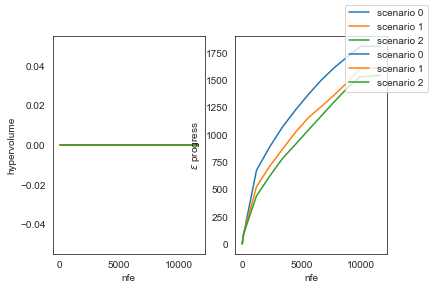

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
for i, (_, convergence) in enumerate(results3):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

In [42]:
from ema_workbench import Policy
from ema_workbench import SequentialEvaluator

policies = []
for i, (result, _) in enumerate(results3):
    result = result.iloc[:, 0:31]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

In [43]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle4 = True

if use_pickle4:
    with open(f"data/MORDM_results4_pf{pf}.pickle","rb") as filehandler:
        reeevaluation_results = pickle.load(filehandler)

else:   
    ema_logging.log_to_stderr(ema_logging.INFO)
        
    with MultiprocessingEvaluator(model) as evaluator:
        reeevaluation_results = evaluator.perform_experiments(100, policies=policies) #was 1000
    
        # Save results in Pickle file
    with open(f"data/MORDM_results4_pf{pf}.pickle","wb") as filehandler:
        pickle.dump(reeevaluation_results,filehandler)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 100 scenarios * 1649 policies * 1 model(s) = 164900 experiments
100%|███████████████████████████████| 164900/164900 [10:46:20<00:00,  4.25it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [44]:
experiments3, outcomes3 = reeevaluation_results

thresholds = {"A.3_Expected Number of Deaths":0.01}

overall_scores = {}
for policy in experiments3.policy.unique():
    logical = experiments3.policy == policy
    scores = {}
    for k, v in outcomes3.items():
        try:
            n = np.sum(v[logical]<=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [45]:
limits = parcoords.get_limits(overall_scores)
print(limits)

   A.3_Expected Number of Deaths
0                          0.001
1                          0.100


In [46]:
print(limits)

   A.3_Expected Number of Deaths
0                          0.001
1                          0.100


In [47]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

UnboundLocalError: local variable 'ax' referenced before assignment

<Figure size 432x288 with 0 Axes>

In [48]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments3['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes3[outcome.name], 
                         "policy":experiments3['policy'],
                         "scenario":experiments3['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()


C:\Users\Mateo\AppData\Local\Temp\ipykernel_14844\3850566153.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14844\3850566153.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14844\3850566153.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
C:\Users\Mateo\AppData\Local\Temp\ipykernel_14844\38

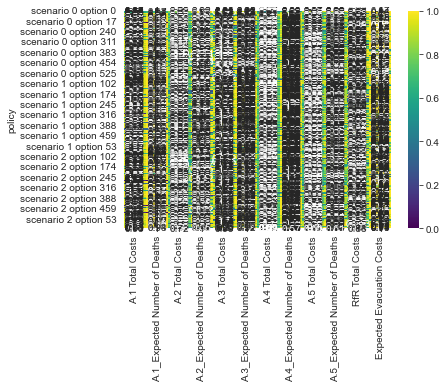

In [49]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

X:\Xrogram-Files\Anaconda\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:197: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
X:\Xrogram-Files\Anaconda\envs\MBDM\lib\site-packages\ema_workbench\analysis\parcoords.py:260: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


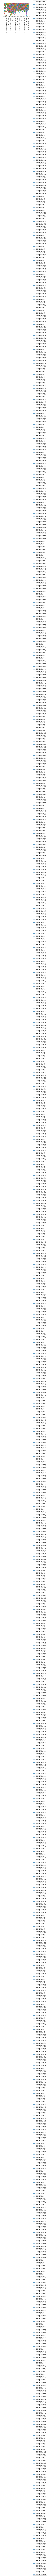

In [50]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, data.keys()] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index))
paraxes.legend()
    
plt.show()